<img src="images/keepcoding.png" width=200 align="left">

# Módulo de Matemáticas 101: práctica

Vamos a poner de nuevo en práctica lo que hemos visto en este módulo. La práctica se centra en la regresión lineal (¡tema muy importante!) y podéis preguntarme las dudas que tengáis por Discord. ¡Mucha suerte!

<img src="./images/luck.gif" alt="Drawing" style="width: 300px;"/>

## 1. Regresión lineal con mínimos cuadrados

En este ejercicio vamos a implementar la forma matricial de la regresión lineal con el método de los mínimos cuadrados. Para ello, tendrás que:

- Explorar un dataset
- Implementar la regresión lineal
- Aplicarla a un dataset concreto

Como recordatorio, los valores de los pesos $\widehat{w}$ vienen dados por:

<center>$\widehat{w} = (X^T X)^{-1}X^T y,$</center>

Donde $y$ es la variable a predecir y $X$ la matriz de features (NOTA: revisa cómo se define en los apuntes). Sabemos que los pesos van a ser los parámetros de la ecuación lineal que estamos intentando ajustar y tendremos uno por cada variable de entrada que usemos y además un término independiente o bias.

### 1.1 Carga del dataset y exploración de datos

Vamos a usar el dataset de [Auto MPG](https://archive.ics.uci.edu/dataset/9/auto+mpg) que podemos encontrar en el [repositorio de Machine learning de UC Irvine](https://archive.ics.uci.edu/). Lo primero, vamos a familiarizarnos con los datos.

En el propio repositorio nos indican cómo descargar el dataset con su librería (podemos consultar el código fuente si queremos).

In [48]:
!pip install ucimlrepo

Defaulting to user installation because normal site-packages is not writeable


In [49]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
auto_mpg = fetch_ucirepo(id=9) 
  
# data (as pandas dataframes) 
X = auto_mpg.data.features 
y = auto_mpg.data.targets 
  
# metadata 
print(auto_mpg.metadata) 
  
# variable information 
print(auto_mpg.variables) 


{'uci_id': 9, 'name': 'Auto MPG', 'repository_url': 'https://archive.ics.uci.edu/dataset/9/auto+mpg', 'data_url': 'https://archive.ics.uci.edu/static/public/9/data.csv', 'abstract': 'Revised from CMU StatLib library, data concerns city-cycle fuel consumption', 'area': 'Other', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 398, 'num_features': 7, 'feature_types': ['Real', 'Categorical', 'Integer'], 'demographics': [], 'target_col': ['mpg'], 'index_col': ['car_name'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1993, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5859H', 'creators': ['R. Quinlan'], 'intro_paper': None, 'additional_info': {'summary': 'This dataset is a slightly modified version of the dataset provided in the StatLib library.  In line with the use by Ross Quinlan (1993) in predicting the attribute "mpg", 8 of the original instances were removed because they had unknown values for th

Con la función `head` de Pandas podemos ver las primeras filas del dataset.

In [50]:
X.head()


,displacement,cylinders,horsepower,weight,acceleration,model_year,origin
0,307.0,8,130.0,3504,12.0,70,1
1,350.0,8,165.0,3693,11.5,70,1
2,318.0,8,150.0,3436,11.0,70,1
3,304.0,8,150.0,3433,12.0,70,1
4,302.0,8,140.0,3449,10.5,70,1


In [51]:
y.head()

,mpg
0,18.0
1,15.0
2,18.0
3,16.0
4,17.0


In [52]:
X[['horsepower']]

,horsepower
0,130.0
1,165.0
2,150.0
3,150.0
4,140.0
...,...
393,86.0
394,52.0
395,84.0
396,79.0


En este punto, puedes hacer cualquier otro análisis exploratorio que creas conveniente.

In [53]:
X[['weight']]

,weight
0,3504
1,3693
2,3436
3,3433
4,3449
...,...
393,2790
394,2130
395,2295
396,2625


A continuación, crea una función a la que le pases los dataframes de features y de target y el nombre de la variable y haga la gráfica del target (consumo en millas por galón) vs la variable que le ha llegado por parámetro. Puedes ver un ejemplo de gráfica más abajo, pero usa los parámetros que quieras en cuanto a color de los puntos, grids etc.

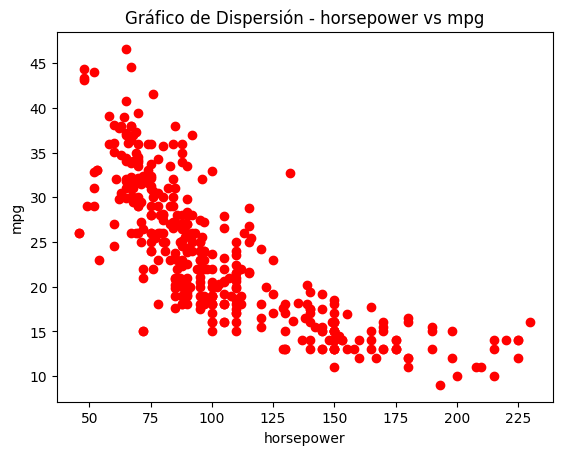

In [54]:
import matplotlib.pyplot as plt

def visualiza(df, y, nombre_columna):
    #plt.scatter(X, y)
    # TODO dibuja la gráfica
    #dataset = X[nombre_columna]
    plt.scatter(X[[nombre_columna]], y, color='red')

    # Etiquetas y título
    plt.title(f'Gráfico de Dispersión - {nombre_columna} vs mpg')
    plt.xlabel(f'{nombre_columna}')
    plt.ylabel('mpg')

    # Mostrar el gráfico

    plt.show()
    

visualiza(X, y, 'horsepower')

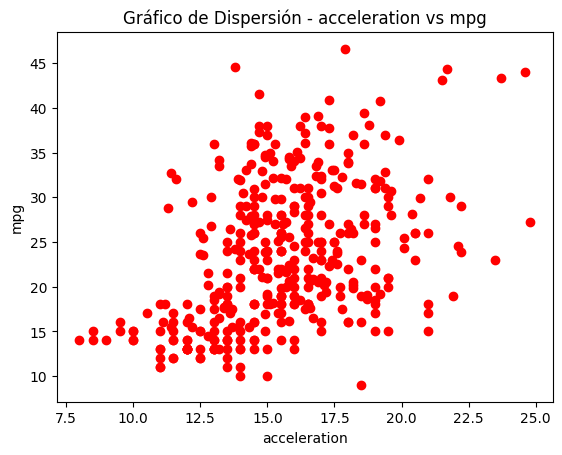

In [34]:
visualiza(X, y, 'acceleration')

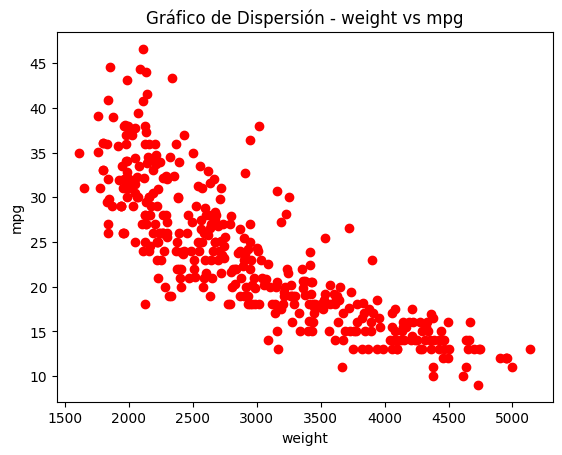

In [35]:
visualiza(X, y, 'weight')

IMPORTANTE: Aunque lo ideal sería un modelo multivariante, vamos a elegir la variable `weight` y hacer una regresión lineal solo con esta variable.

### 1.2 Implementación del modelo

En este punto vamos a dar un paso atrás y olvidarnos de los datos de consumo por un momento, porque el algoritmo que vamos a implementar serviría para cualquier conjunto de datos.

Lo primero, implementa una función que devuelva los valores de $\widehat{w}$ dados X e y. Si se da el caso de que el dataset tiene más features que observaciones, queremos transponerlo antes de realizar las operaciones. Lo hacemos porque, como vimos en clase, los resultados no van a ser buenos si el número de observaciones es menor.

In [57]:
import numpy as np

def pesos_ols(X, y):
    # Implementa la fórmula matricial
    
    # TODO 1 Comprueba que las dimensiones son adecuadas y corrige si no es así
    # Revisamos las dimensiones utilizando el metodo shape y si no son las adecuadas generamos la traspuesta.
    if X.shape[0] < X.shape[1]:
        X = X.T
    
    # TODO 2 Prepara la matriz X para que tenga la forma adecuada para aplicar la fórmula 
    ones = np.ones((X.shape[0], 1)) 
    X_b = np.hstack((ones, X))

    # TODO 3 Calcula los pesos
    w = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
    return w

In [71]:
# Array de prueba!!
X = np.array([[1710, 1262, 1786, 1717, 2198, 1362, 1694, 2090, 1774, 1077], 
              [2003, 1976, 2001, 1915, 2000, 1993, 2004, 1973, 1931, 1939]])
y = np.array([208500, 181500, 223500, 140000, 250000, 143000, 307000, 200000, 129900, 118000])
pesos_ols(X, y)

array([-2.29223802e+06,  5.92536529e+01,  1.20780450e+03])

Hemos implementado el algoritmo de mínimos cuadrados y lo hemos probado en un array de tamaño 2x10. Como pista, el resultado que he obtenido para este array de prueba es el siguiente:

array([-2.29223802e+06,  5.92536529e+01,  1.20780450e+03])

### 1.3 Prueba del modelo en los datos de consumo de coches

Ya podemos usar nuestra función `pesos` en el dataset real que hemos descargado, el de consumo de combustible. Para ver el ajuste, dibuja de nuevo los datos junto con la recta que has obtenido, en la misma gráfica. Tendrás que convertir los dataframes de Pandas en arrays de numpy para poder aplicar las operaciones matriciales.

TIP: Revisa las dimensiones de todos los arrays para ver que son correctas.

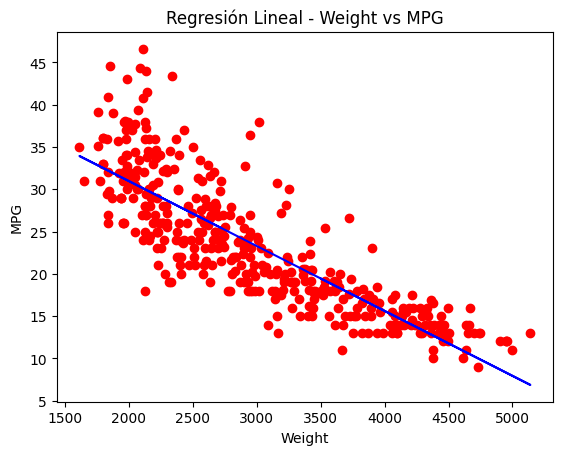

In [68]:
# TODO Aplica el modelo y dibuja la recta junto con los datos
# Volvemos a cargar dataset original
# fetch dataset 
auto_mpg = fetch_ucirepo(id=9) 
  
# data (as pandas dataframes) 
X = auto_mpg.data.features 
y = auto_mpg.data.targets 

# modelo de regresion lineal usando matrices.
X_np = X[['weight']].to_numpy()
y_np = y.to_numpy()
pesos = pesos_ols(X_np, y_np)
y_calc = pesos[0] + pesos[1] * X_np

# Mostramos los graficos y la recta

plt.scatter(X_np, y_np, color='red')
plt.plot(X_np, y_calc, color="blue")
plt.title("Regresión Lineal - Weight vs MPG")
plt.xlabel("Weight")
plt.ylabel("MPG")
plt.show()

Por último, vamos a comprar el resultado con el que nos da `scikit-learn`para ver si nuestra implementación tiene buena pinta. Podemos ver cómo funciona en la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [69]:
from sklearn.linear_model import LinearRegression

# Creamos el objeto
lr = LinearRegression()

# Le pasamos los datos en el formato correcto
X = auto_mpg.data.features 
y = auto_mpg.data.targets 

X_lr = X[['weight']]
y_lr = y

# Entrenamos con los datos
lr.fit(X_lr,y_lr)
print("Punto de corte:", lr.intercept_)
print("Pendiente:", lr.coef_)

Punto de corte: [46.31736442]
Pendiente: [[-0.00767661]]


**TODO**: Analiza el resultado obtenido y compáralo con el de sklearn

In [70]:
# Obtenemos los mismos datos pero con el modelo de numpy a través de los pesos calculados.
print("Punto de corte:", pesos[0])
print("Pendiente:", pesos[1])

Punto de corte: [46.31736442]
Pendiente: [-0.00767661]


Se demuestra que el resultado obtenido es el mismo a través de los dos metodos, esto también nos indica que el modelo que hemos creado de minimos cuadrados están bien implementado. Aunque es más sencillo utilizar la funcion de regresion lineal, ya que no hay opción a equivocarse en la aplicación del modelo calculando las diferentes matrices.

### 1.4 Compara el método de mínimos cuadrados y el descenso del gradiente para obtener los coeficientes de una regresión lineal



**método de mínimos cuadrados** aplica una formula matemática para calcular los coeficientes de la regresión lineal, que podemos convertir en matrices y simplificar los calculos, proporcionando una solución exacta. Es rápido y muy eficiente en conjuntos de datos pequeños o medianos, pero no es optimo con conjuntos de datos grandes debido al coste computacional de calcular las matrices inversas. 

**descenso del gradiente** es un algoritmo iterativo que encuentra los coeficientes de regresión mediante la búsqueda de un mínimo local en la función de costo (la suma de los errores al cuadrado).  Ajusta iterativamente los coeficientes, moviéndose en la dirección opuesta al gradiente de la función de costo hasta que se converge a un mínimo (o se alcanza un criterio de parada). Este método es muy optimo con modelos de datos grantes, no tiene que invertir matrices.

Como conclusión podemos asegurar que para conjuntos de datos pequeños o medianos el método de minimos cuadrados seria muy eficiente, mientras que para conjuntos de datos grandes es mejor utilizar el modelo del descenso del gradiente para el calculo de una regresión lineal de ese conjunto de datos. 


